# Linking In Style

Here we provide minimal code to visualize and analyze individual units using our proposed method <br>
You will only need a small set of libraries to run the code (numpy, pandas and matplotlib). <br> 
We will make the full code base available upon publication.

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
import pandas as pd
import matplotlib
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 22})
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False

In [7]:
labels = ['leg', 'body', 'tail', 'tongue', 'eye', 'nose', 'snout', 'ear', 'head']

def get_feat_change_single_unit(df, unit):
    feat_names = ['area', 'luminance', 'mean_entropy']
    changes = {'label': []}
    for feat_name in feat_names:
        changes[feat_name] = []

    df_ = df[df['unit']  == unit]
    # print(df_)
    df_0 = df_[df_['seq_i'] == 0]
    df_2 = df_[df_['seq_i'] == 2]
    array_0 = np.array(df_0[feat_names])
    array_2 = np.array(df_2[feat_names])
    diff = array_2 - array_0
    scaler = array_0[:, 0]
    scaler[scaler == 0] = 1
    diff[:, 0] /= scaler
    diff[:, 1] /= 85     # 85 = max luminance
    for l, label in enumerate(labels):
        changes['label'].append(label)
        for f, feat_name in enumerate(feat_names):
            try:
                changes[feat_name].append(diff[l, f])
            except IndexError:
                print(unit, label)
                continue
    return pd.DataFrame.from_dict(changes)

def get_ellips_change_single_unit(df, unit):
    feat_names = ['eccentricity', 'angle', 'center_x', 'center_y', 'width', 'height']
    certain_labels = ['body', 'tongue', 'nose', 'snout', 'head', 'stem', 'cap']
    changes = {'label': []}
    for feat_name in feat_names:
        changes[feat_name] = []

    df_ = df[df['unit']  == unit]
    for l, label in enumerate(labels):
        label_df = df_[df_['label'] == label]
        if len(label_df) == 3 or label in certain_labels:
            ellips_0 = label_df[label_df['seq_i'] == 0]
            ellips_2 = label_df[label_df['seq_i'] == 2]
            if len(ellips_0) != 1 or len(ellips_2) != 1:
                unique_i = np.unique(label_df['ellips_i'])
                unique_i = unique_i[~np.isnan(unique_i)]
                for f, feat_name in enumerate(feat_names):
                    changes_ = []
                    for ellips_i in unique_i:
                        ellips_i_df = label_df[label_df['ellips_i'] ==  ellips_i]
                        if len(ellips_i_df) != 3:
                            continue
                        ellips_0 = ellips_i_df[ellips_i_df['seq_i'] == 0]
                        ellips_2 = ellips_i_df[ellips_i_df['seq_i'] == 2]
                        try:
                            changes_.append(ellips_2[feat_name].item() - ellips_0[feat_name].item())
                        except:
                            changes_.append(0)
                    changes[feat_name].append(np.mean(changes_))
                changes['label'].append(label)

            else:
                for f, feat_name in enumerate(feat_names):
                    try:
                        changes[feat_name].append(ellips_2[feat_name].item() - ellips_0[feat_name].item())
                    except ValueError:
                        print(unit, label, feat_name, len(ellips_0), len(ellips_2))
                        changes[feat_name].append(0)

                # if add_item:
                changes['label'].append(label)
        # if label in certain_labels:
        else:    
            unique_i = np.unique(label_df['ellips_i'])
            unique_i = unique_i[~np.isnan(unique_i)]
            for f, feat_name in enumerate(feat_names):
                changes_ = []
                for ellips_i in unique_i:
                    ellips_i_df = label_df[label_df['ellips_i'] ==  ellips_i]
                    if len(ellips_i_df) != 3:
                        continue
                    ellips_0 = ellips_i_df[ellips_i_df['seq_i'] == 0]
                    ellips_2 = ellips_i_df[ellips_i_df['seq_i'] == 2]
                    try:
                        changes_.append(ellips_2[feat_name].item() - ellips_0[feat_name].item())
                    except:
                        changes_.append(0)
                changes[feat_name].append(np.mean(changes_))
            changes['label'].append(label)
    return pd.DataFrame.from_dict(changes)



def get_example_image(img_path, unit):
    img = PIL.Image.open(os.path.join(img_path, str(unit) + '.png'))
    return img

def plot_features(changes_df, changes_ellips_df, colors, thresh_cols, one_line=False):
    if one_line:
        fig, axs = plt.subplots(figsize=(18, 4), ncols=5)
    else:
        fig, axs = plt.subplots(figsize=(12, 8), ncols=3, nrows=2)

    
    ylims = [(-1, 1), (-.5, .5), (-.5, .5), (-.5, .5), (-180, 180)]
    titles = ['Area', 'Luminance', 'Entropy', 'Eccentricity', 'Angle (°)']
    ylabels = ['∆ Area', '∆ Luminance', '∆ Entropy', '∆ Eccentr.', '∆ Angle']
    
    columns_feats = ['area', 'luminance', 'mean_entropy']
    columns_ellips = ['eccentricity', 'angle']

    for c, col in enumerate(columns_feats):
        res = changes_df[col].copy()

        ax = axs[c] if one_line else axs[0, c]
        res[thresh_cols] = 0
        ax.bar(np.arange(len(res)), res, color=colors, edgecolor='k')
        ax.set_xticks(np.arange(len(labels)), changes_df['label'], rotation=90)

    for c, col in enumerate(columns_ellips):
        ax = axs[c+3] if one_line else axs[1, c]
        ellips_count = 0
        ticks_i, ticks_label = [], []
        for l, label in enumerate(labels):
            if l in thresh_cols:
                continue
            label_df = changes_ellips_df[changes_ellips_df['label'] == label]
            
            if len(label_df):
                res = label_df[col]
                ax.bar(np.arange(len(res)) + ellips_count, res, color=colors[l], edgecolor='k')
                ticks_label.append(label)
                ticks_i.append(ellips_count) 
                ellips_count += len(res)
        ax.set_xticks(ticks_i, ticks_label, rotation=90)

    for i, (ylabel, title, ylim) in enumerate(zip(ylabels, titles, ylims)):
        ax = axs[i] if one_line else axs[i//3, i%3]
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.set_ylim(ylim)
    
    fig.tight_layout()
    plt.show()
    

def plot_features_vector(change_vector, colors,one_line=False):
    if one_line:
        fig, axs = plt.subplots(figsize=(18, 4), ncols=5)
    else:
        fig, axs = plt.subplots(figsize=(12, 8), ncols=3, nrows=2)

    
    ylims = [(-1, 1), (-.5, .5), (-.5, .5), (-.5, .5), (-180, 180)]
    titles = ['Area', 'Luminance', 'Entropy', 'Eccentricity', 'Angle (°)']
    ylabels = ['∆ Area', '∆ Luminance', '∆ Entropy', '∆ Eccentr.', '∆ Angle']
    
    columns_feats = ['area', 'luminance', 'mean_entropy', 'eccentricity', 'angle']

    for c, col in enumerate(columns_feats):
        ax = axs[c] if one_line else axs[c//3, c]
        ax.bar(np.arange(len(labels)), change_vector[..., c], color=colors, edgecolor='k')
        ax.set_xticks(np.arange(len(labels)), labels, rotation=90)

    for i, (ylabel, title, ylim) in enumerate(zip(ylabels, titles, ylims)):
        ax = axs[i] if one_line else axs[i//3, i%3]
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.set_ylim(ylim)
    
    fig.tight_layout()
    plt.show()

    
def plot_results(img, changes_df, changes_ellips_df, colors, thresh_cols, one_line=False):
    fig = plt.figure(figsize=(12, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    plot_features(changes_df, changes_ellips_df, colors, thresh_cols, one_line=one_line)
    

def visualize_unit(unit, class_i='151', seed=6, thresh=20, one_line=True, 
                   file_path= './data/'):
    
    colors = []
    cmap =  plt.get_cmap('Set3')
    colors.extend([cmap(i) for i in range(len(labels))])
    analysis_res = pd.read_csv(os.path.join(file_path, str(class_i), str(seed), 'analysis_results.csv')) 
    thresh_cols = np.where(np.mean(np.array(analysis_res[analysis_res['unit'] == unit]['area']).reshape(len(labels), 3), axis=-1) < thresh)[0]    
    feat_changes = get_feat_change_single_unit(analysis_res, unit)
    
    ellipses = pd.read_csv(os.path.join(file_path, str(class_i), str(seed), 'ellips_results.csv')) 
    changes_ellips_df = get_ellips_change_single_unit(ellipses, unit)
    
    img = get_example_image(os.path.join(file_path, str(class_i), str(seed)), unit)

    plot_results(np.array(img), feat_changes, changes_ellips_df, colors, thresh_cols, one_line=one_line)
    

## Visualizing a single unit including the quantification metrics

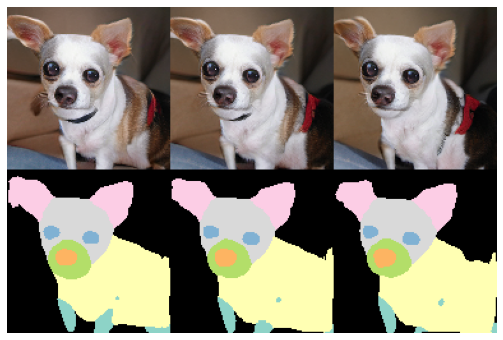

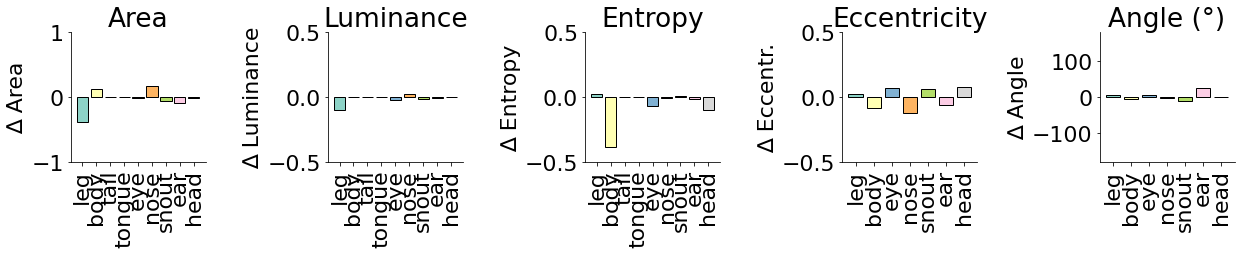

In [19]:
# change the unit variable to display a different unit (min=0, max=999)
# Due to size limits of the supplement, we only included the first 1,000 units of the classifier
unit = 420

visualize_unit(unit)

## Visualizing several units

In [11]:
def visualize_different_units(units, seed=6, class_i=151, file_path='./data'):
    imgs = []
    for unit in units:
        img = get_example_image(os.path.join(file_path, str(class_i), str(seed)), unit)
        img = np.array(img)
        img = img[:128]
        imgs.append(img)
    imgs = PIL.Image.fromarray(np.concatenate(imgs, axis=0))
    imgs.show()

In [27]:
# change this for the different units (min=0, max=999)
units = [530, 940, 6]

visualize_different_units(units)